<a href="https://colab.research.google.com/github/markjschmidt/PET_List/blob/main/My_Anthropic_PET_Randoms_576_List_20250513.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I'll adapt our previous code to work with the new 3OCLK_0_1000.txt file and create visualizations specific to a point source at the 3 o'clock position. I'll ensure the code can handle both the sample file you shared here and the full 8 MB file when uploaded to Colab.

I've created a comprehensive Python script specifically optimized for analyzing your 3 o'clock point source PET data. This code is designed to work in Google Colab and will handle both the sample data you provided and the full 8MB file.

## Key Features

### 1. File Handling
- The script prompts for file upload using Colab's file upload interface
- Works with both small samples and large files (8MB+)
- Efficiently parses PROMPT and DELAY events from the listPrint format

### 2. Point Source Visualizations
- **Event Pairs Visualization**: Shows LORs (Lines of Response) connecting xa-xb detector pairs with the point source marked at the 3 o'clock position
- **Detector Activation Heatmap**: Displays which detectors are most active around the ring using a color gradient
- **TOF Value Histogram**: Analyzes the distribution of Time-of-Flight values, which should show a distinctive pattern with a point source
- **TOF vs Detector Position**: Explores the relationship between TOF values and detector positions (xa and xb)
- **Detector Pair Grid**: Shows the frequency of specific xa-xb detector combinations as a 2D heatmap

### 3. Data Analysis
- Provides summary statistics for the dataset
- Identifies most active detectors
- Analyzes the 180° relationship between detector pairs
- Calculates TOF statistics (min, max, mean, median, std dev)

## What to Expect

Since the point source is positioned at 3 o'clock (0°), you should see:

1. LORs that predominantly pass through the point source location
2. Higher detector activation near 0° (3 o'clock) and 180° (9 o'clock)
3. A TOF distribution that may be skewed/shifted (positive or negative) depending on the source's exact position relative to the center of the FOV
4. The 180° relationship analysis should show how closely the detector pairs align with the theoretical 180° opposite positions

To use this in Colab:
1. Upload the notebook
2. Run all cells
3. When prompted, upload either your 3OCLK_0_1000.txt file or the full 8MB dataset
4. The script will automatically generate all visualizations

The code is optimized to handle large files efficiently, so it should work well with your full 8MB dataset.

=== Vereos PET Scanner Point Source Analysis ===
Please upload your LOR data file (e.g., '3OCLK_0_1000.txt' or the full 8MB file):


Saving 576fov_500k.txt to 576fov_500k.txt

Processing file: 576fov_500k.txt
Successfully processed 1126733 events.

=== PET Scanner Data Summary ===
Total Events: 1126733
Unique xa detectors activated: 448 out of 576
Unique xb detectors activated: 448 out of 576
TOF Range: -103 to 103

Top 5 most active xa detectors:
  Detector 7: 4316 events
  Detector 18: 4312 events
  Detector 11: 4252 events
  Detector 13: 4222 events
  Detector 10: 4198 events

Top 5 most active xb detectors:
  Detector 551: 4352 events
  Detector 519: 4245 events
  Detector 568: 4243 events
  Detector 533: 4202 events
  Detector 534: 4201 events

180° Relationship Analysis:
  Mean deviation from 180°: 80.24 crystals
  Median deviation: 80.00 crystals
  Standard deviation: 46.35 crystals
  Events within 5 crystals of exact opposite: 3.5%

Generating PET Ring Visualization...


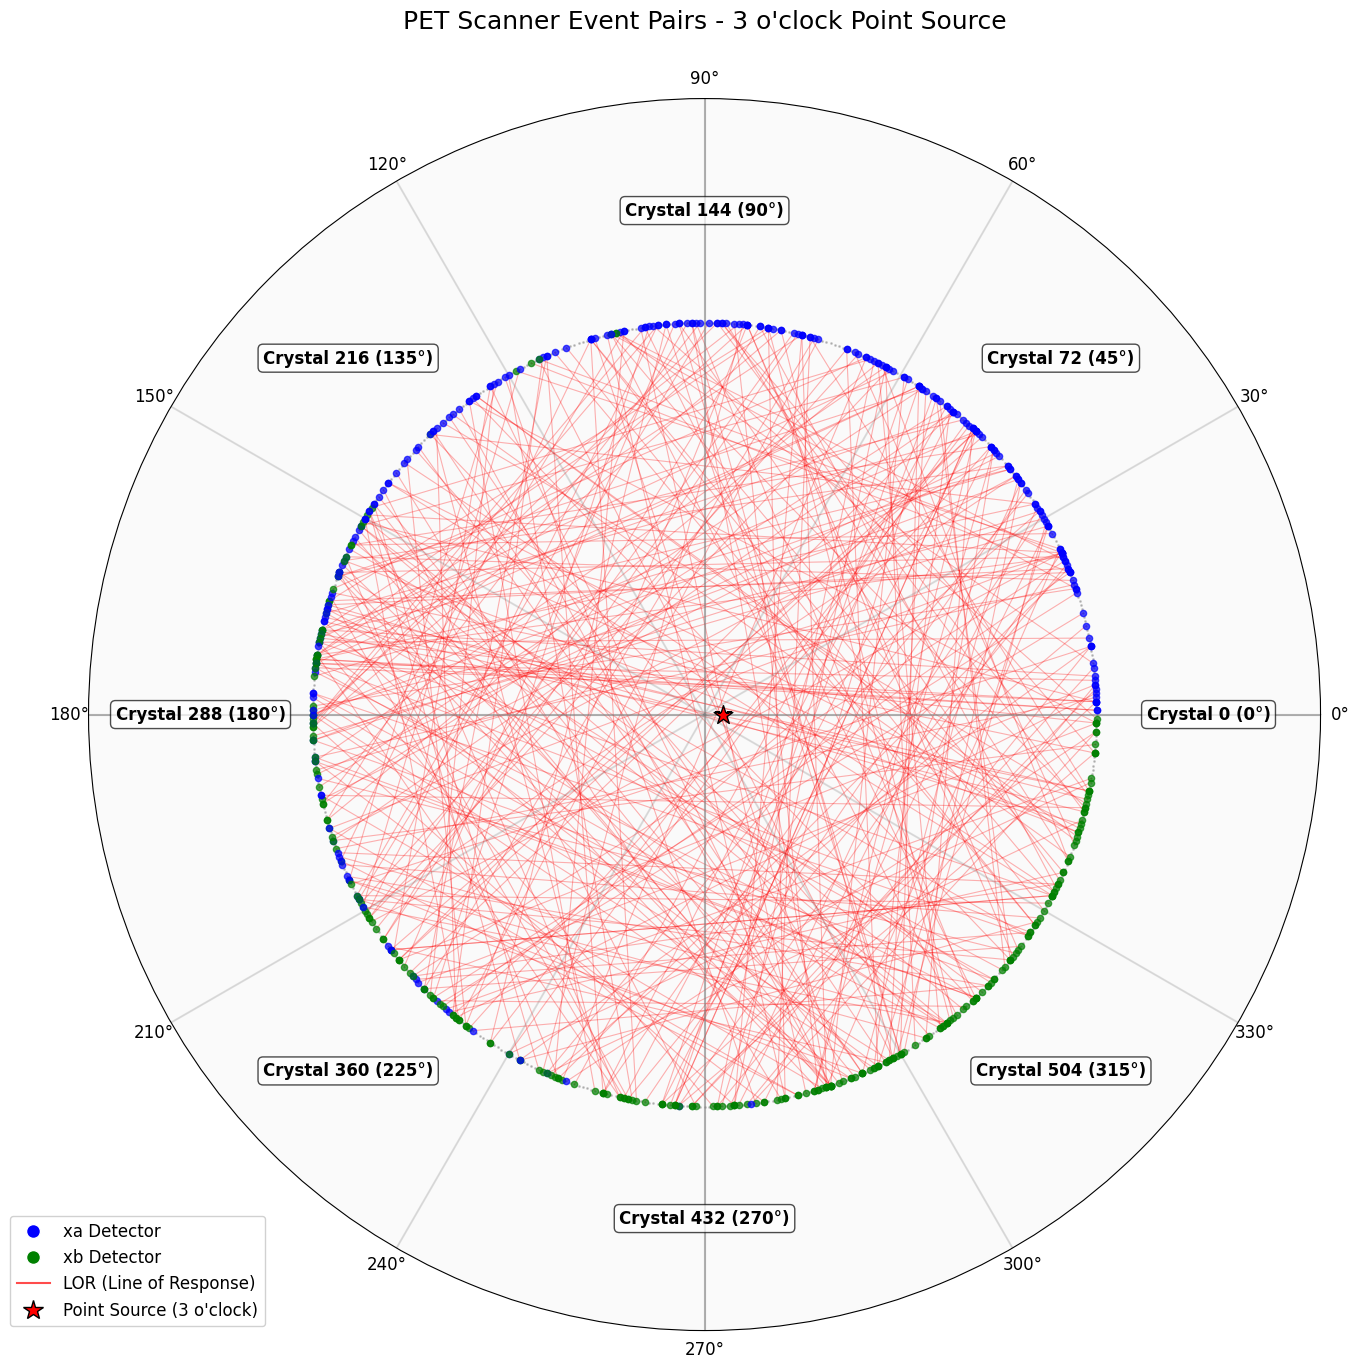


Generating Detector Activation Heatmap...


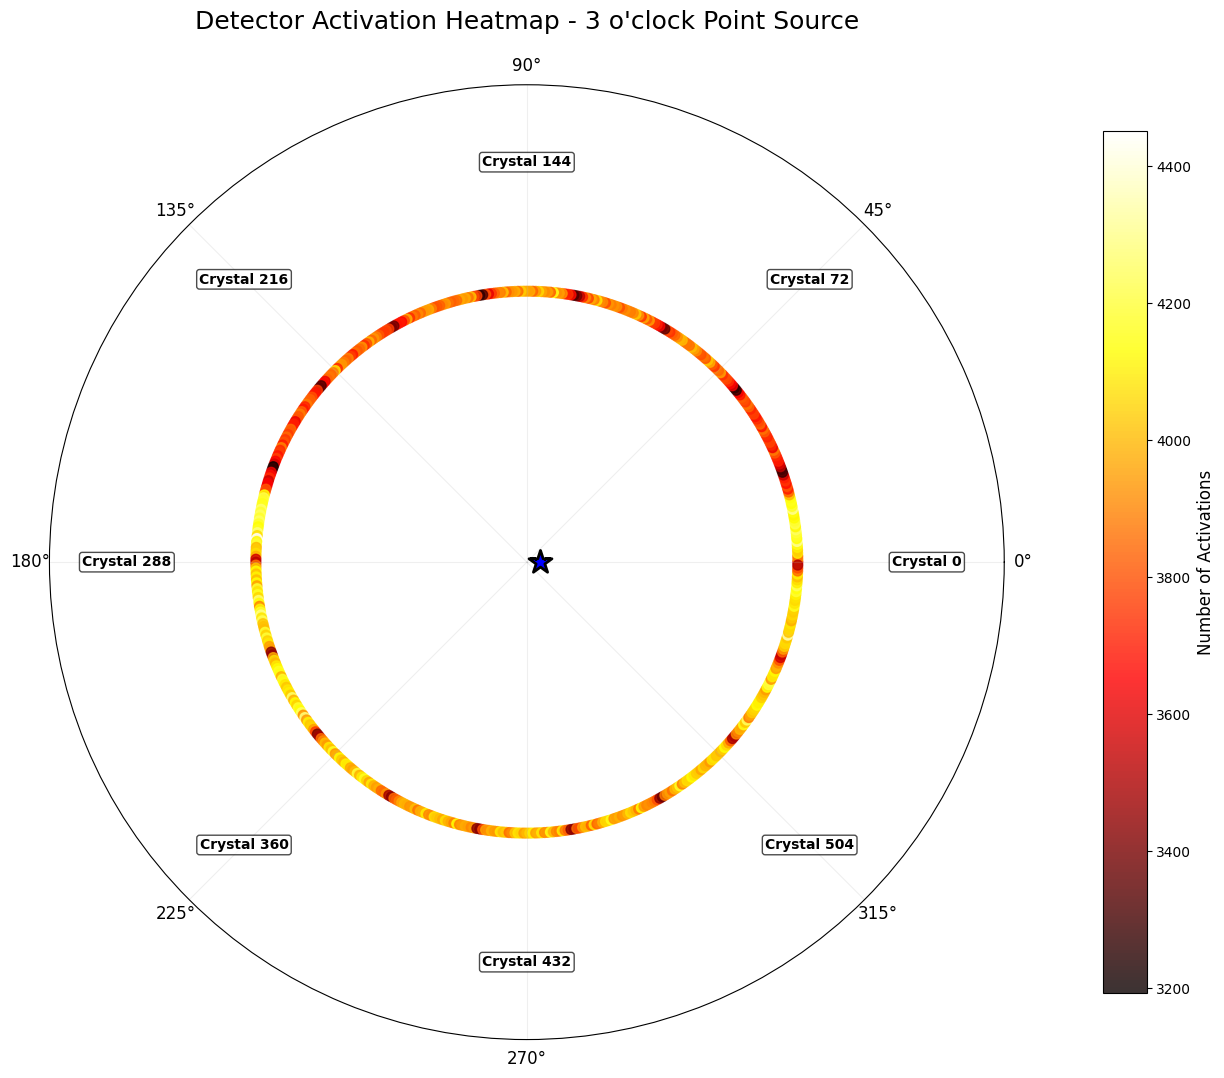


Generating TOF Distribution Analysis...


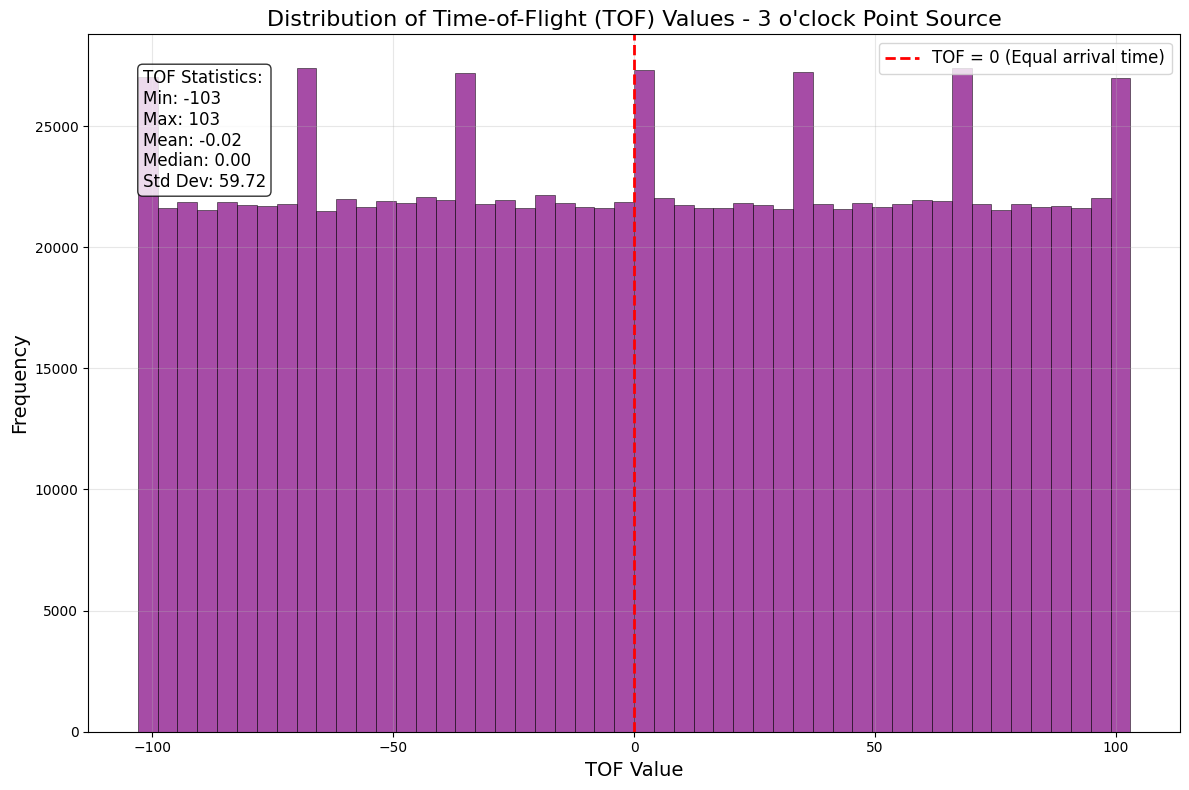


Analyzing TOF values versus detector positions...


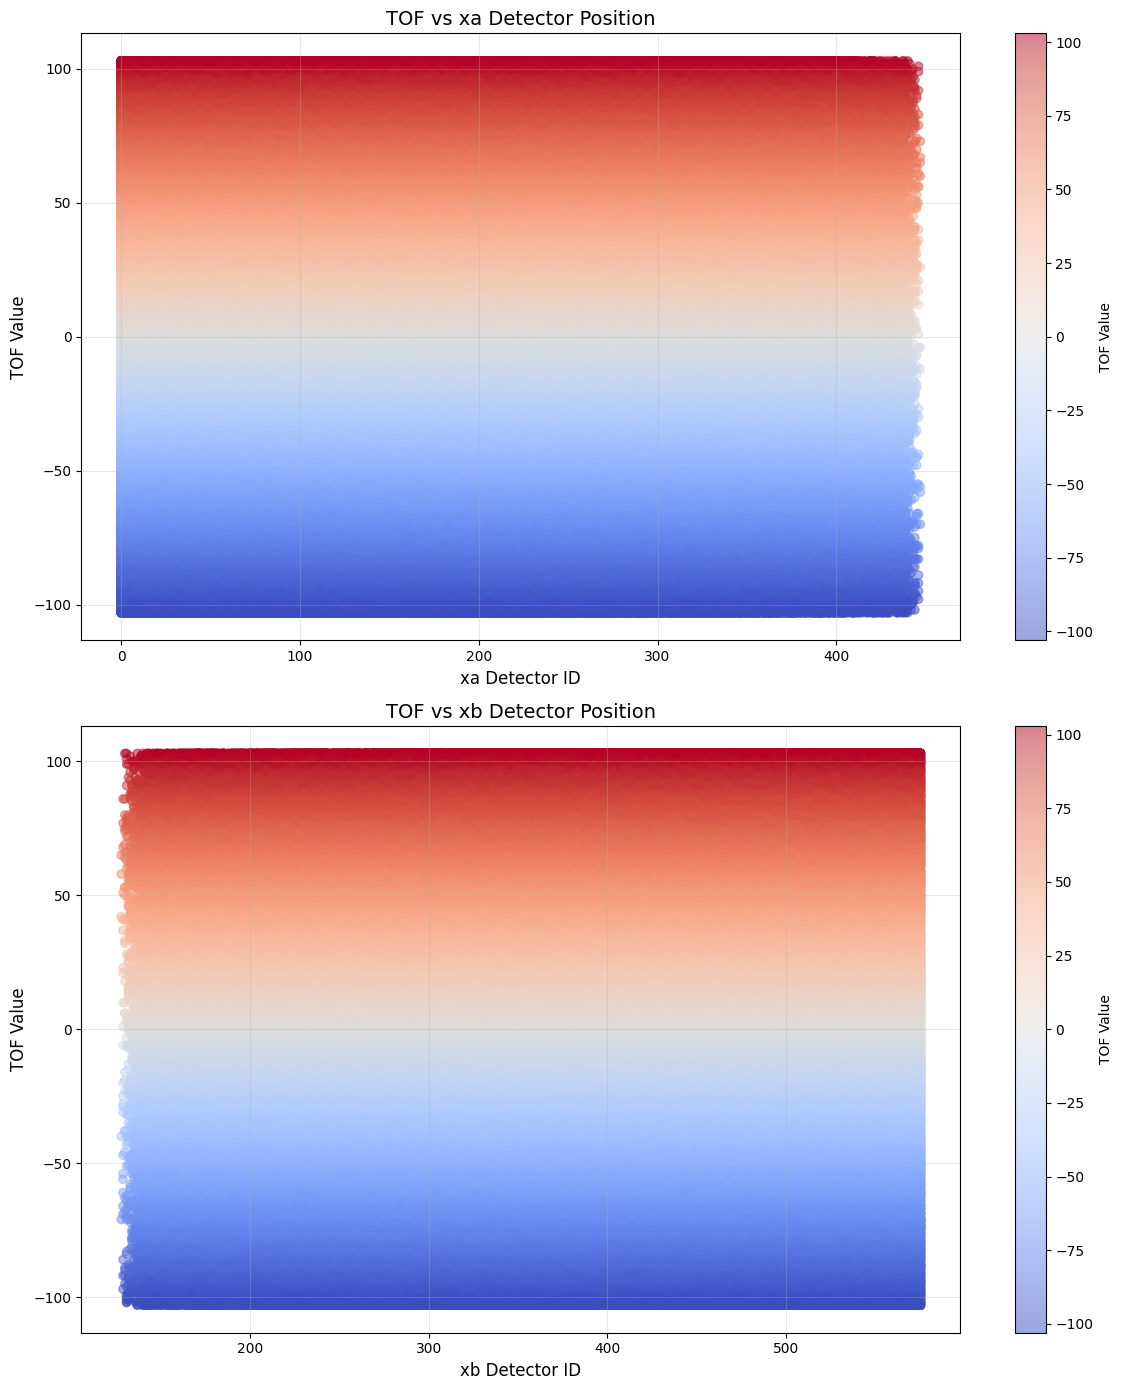


Generating xa-xb Detector Pair Heatmap...


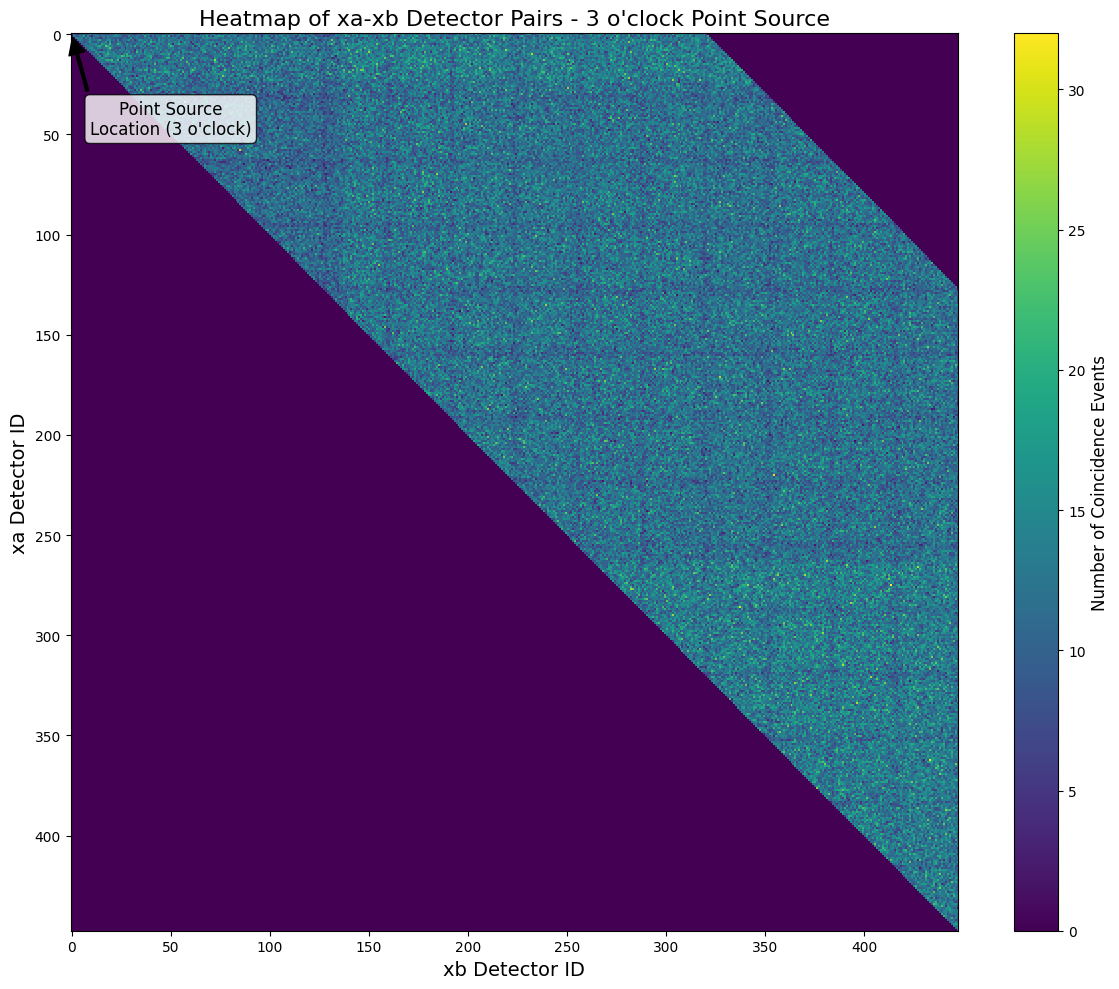


Analysis complete! All visualizations have been generated.


In [ ]:
# PET Scanner Point Source Visualization
# Analyzes PET scanner LOR data from a point source positioned at 3 o'clock

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from google.colab import files
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Enable Plotly in Colab
pio.renderers.default = 'colab'

# Function to extract values from parentheses for each metric
def extract_values(line):
    pattern = r'xa\((\d+)\) xb\((\d+)\) tof\(([-]?\d+)\) za\((\d+)\) zb\((\d+)\)'
    match = re.search(pattern, line)
    if match:
        return {
            'xa': int(match.group(1)),
            'xb': int(match.group(2)),
            'tof': int(match.group(3)),
            'za': int(match.group(4)),
            'zb': int(match.group(5))
        }
    return None

# Function to process file content - works with both small and large files
def process_file_content(file_content):
    data_list = []

    for line in file_content.split('\n'):
        # Check if line contains PROMPT or DELAY and the required data
        if ('PROMPT:' in line or 'DELAY:' in line) and 'xa(' in line:
            values = extract_values(line)
            if values:
                data_list.append(values)

    # Create DataFrame
    df = pd.DataFrame(data_list)
    return df

# Improved event pair visualization tailored for 3 o'clock point source
def create_point_source_visualization(df, title='PET Scanner Event Pairs - 3 o\'clock Point Source'):
    # Create a sample of events to visualize (to avoid overcrowding)
    # For a point source, we might want to show more events to see the pattern
    sample_size = min(300, len(df))
    sample_df = df.sample(sample_size, random_state=42)

    # Calculate angles for xa and xb (Crystal 0 at RIGHT (0°), CLOCKWISE)
    sample_df['xa_angle_deg'] = (sample_df['xa'] * 360 / 576) % 360
    sample_df['xb_angle_deg'] = (sample_df['xb'] * 360 / 576) % 360

    # Convert to radians for polar plotting
    sample_df['xa_angle_rad'] = np.radians(sample_df['xa_angle_deg'])
    sample_df['xb_angle_rad'] = np.radians(sample_df['xb_angle_deg'])

    # Create figure
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111, polar=True)

    # Draw PET detector ring
    ring_radius = 1
    ring = plt.Circle((0, 0), ring_radius, transform=ax.transData._b,
                      color='lightgray', fill=False, linewidth=2)
    ax.add_artist(ring)

    # Add a filled circle for the detector ring background
    detector_bg = plt.Circle((0, 0), ring_radius + 0.05, transform=ax.transData._b,
                             color='lightgray', fill=True, alpha=0.1)
    ax.add_artist(detector_bg)

    # Create small markers at each crystal position to represent the detector ring
    crystal_angles = np.linspace(0, 2*np.pi, 576, endpoint=False)
    ax.scatter(crystal_angles, [ring_radius]*576, s=1, color='gray', alpha=0.4)

    # --------- Plot event pairs with lines connecting xa and xb ---------
    for idx, row in sample_df.iterrows():
        # Draw LOR (Line of Response) connecting xa and xb
        ax.plot([row['xa_angle_rad'], row['xb_angle_rad']], [ring_radius, ring_radius],
                color='red', alpha=0.3, linewidth=0.8)

        # Plot xa point (blue)
        ax.scatter(row['xa_angle_rad'], ring_radius, s=20, color='blue', alpha=0.7, zorder=3)

        # Plot xb point (green)
        ax.scatter(row['xb_angle_rad'], ring_radius, s=20, color='green', alpha=0.7, zorder=3)

    # Highlight the 3 o'clock position (point source location)
    source_angle = np.radians(0)  # 0° = 3 o'clock position
    ax.scatter(source_angle, 0.5, s=200, color='red', marker='*', edgecolor='black', linewidth=1, zorder=5)

    # Set the direction to clockwise and start from the right (0°)
    ax.set_theta_direction(1)  # Clockwise
    ax.set_theta_offset(0)     # Start at right (0°)

    # Remove radial ticks
    ax.set_rticks([])

    # Create full 360° labels every 30 degrees
    angles = np.arange(0, 360, 30)
    labels = [f'{angle}°' for angle in angles]
    label_positions = np.radians(angles)
    ax.set_xticks(label_positions)
    ax.set_xticklabels(labels, fontsize=12)

    # Highlight key angular positions with grid lines
    for angle in np.arange(0, 2*np.pi, np.pi/6):  # Every 30 degrees
        ax.axvline(angle, color='gray', alpha=0.2)

    for angle in np.arange(0, 2*np.pi, np.pi/2):  # Every 90 degrees
        ax.axvline(angle, color='gray', alpha=0.5, linewidth=1.5)

    # Add crystal position markings and labels
    crystal_positions = [0, 72, 144, 216, 288, 360, 432, 504]
    crystal_angles_deg = [(pos * 360 / 576) % 360 for pos in crystal_positions]
    crystal_angles_rad = [np.radians(angle) for angle in crystal_angles_deg]

    # Create crystal labels with positions
    crystal_labels = {
        0: "Crystal 0 (0°)",
        72: "Crystal 72 (45°)",
        144: "Crystal 144 (90°)",
        216: "Crystal 216 (135°)",
        288: "Crystal 288 (180°)",
        360: "Crystal 360 (225°)",
        432: "Crystal 432 (270°)",
        504: "Crystal 504 (315°)"
    }

    # Add crystal position annotations
    for pos, angle in zip(crystal_positions, crystal_angles_rad):
        ax.annotate(crystal_labels[pos], xy=(angle, 1.15),
                   xytext=(angle, 1.15),
                   horizontalalignment='center', verticalalignment='center',
                   fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

    # Add title
    plt.title(title, size=18, y=1.05)

    # Add a light grid
    ax.grid(True, alpha=0.2)

    # Add legend with improved styling and positioning
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='xa Detector'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='xb Detector'),
        Line2D([0], [0], color='red', alpha=0.7, label='LOR (Line of Response)'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=15,
               markeredgecolor='black', label='Point Source (3 o\'clock)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.15, 0.1),
              frameon=True, framealpha=0.9, fontsize=12)

    # Set radius limits to show labels clearly
    ax.set_rmax(ring_radius + 0.3)

    return fig

# Function to create heatmap of detector activations on the ring
def create_detector_heatmap(df, title='Detector Activation Heatmap - 3 o\'clock Point Source'):
    # Create frequency counts for each detector
    xa_counts = df['xa'].value_counts().reset_index()
    xa_counts.columns = ['detector_id', 'xa_frequency']

    xb_counts = df['xb'].value_counts().reset_index()
    xb_counts.columns = ['detector_id', 'xb_frequency']

    # Merge into single dataframe with all 576 detectors
    all_detectors = pd.DataFrame({'detector_id': range(576)})
    all_detectors = pd.merge(all_detectors, xa_counts, on='detector_id', how='left')
    all_detectors = pd.merge(all_detectors, xb_counts, on='detector_id', how='left')

    # Fill NaN values with 0
    all_detectors = all_detectors.fillna(0)

    # Calculate total activations
    all_detectors['total_activations'] = all_detectors['xa_frequency'] + all_detectors['xb_frequency']

    # Calculate angles for plotting
    all_detectors['angle_deg'] = (all_detectors['detector_id'] * 360 / 576) % 360
    all_detectors['angle_rad'] = np.radians(all_detectors['angle_deg'])

    # Create figure
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111, polar=True)

    # Plot total activations as colored points on the ring
    scatter = ax.scatter(all_detectors['angle_rad'],
                         np.ones(len(all_detectors)) * 1.0,  # At radius 1
                         c=all_detectors['total_activations'],
                         s=50,
                         cmap='hot',
                         alpha=0.8)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, pad=0.08)
    cbar.set_label('Number of Activations', fontsize=12)

    # Highlight the 3 o'clock position (point source location)
    source_angle = np.radians(0)  # 0° = 3 o'clock position
    ax.scatter(source_angle, 0.5, s=300, color='blue', marker='*', edgecolor='black', linewidth=2, zorder=5)

    # Set the direction to clockwise and start from the right (0°)
    ax.set_theta_direction(1)  # Clockwise
    ax.set_theta_offset(0)     # Start at right (0°)

    # Remove radial ticks
    ax.set_rticks([])

    # Create full 360° labels every 45 degrees
    angles = np.arange(0, 360, 45)
    labels = [f'{angle}°' for angle in angles]
    label_positions = np.radians(angles)
    ax.set_xticks(label_positions)
    ax.set_xticklabels(labels, fontsize=12)

    # Add key crystal position markings and labels
    crystal_positions = [0, 72, 144, 216, 288, 360, 432, 504]
    crystal_angles_deg = [(pos * 360 / 576) % 360 for pos in crystal_positions]
    crystal_angles_rad = [np.radians(angle) for angle in crystal_angles_deg]

    # Add crystal position annotations
    for pos, angle in zip(crystal_positions, crystal_angles_rad):
        ax.annotate(f'Crystal {pos}', xy=(angle, 1.25),
                   xytext=(angle, 1.25),
                   horizontalalignment='center', verticalalignment='center',
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))

    # Add title
    plt.title(title, size=18, y=1.05)

    # Add a light grid
    ax.grid(True, alpha=0.2)

    # Set radius limits to show labels clearly
    ax.set_rmax(1.4)

    return fig

# Function to analyze TOF values
def analyze_tof_distribution(df):
    # Create figure for TOF histogram
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create histogram of TOF values
    hist = ax.hist(df['tof'], bins=50, color='purple', alpha=0.7, edgecolor='black', linewidth=0.5)

    # Mark the zero TOF value
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2,
               label='TOF = 0 (Equal arrival time)')

    # Add labels and title
    ax.set_xlabel('TOF Value', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title('Distribution of Time-of-Flight (TOF) Values - 3 o\'clock Point Source', fontsize=16)

    # Add grid for readability
    ax.grid(True, alpha=0.3)

    # Add statistics as text
    stats_text = (
        f"TOF Statistics:\n"
        f"Min: {df['tof'].min()}\n"
        f"Max: {df['tof'].max()}\n"
        f"Mean: {df['tof'].mean():.2f}\n"
        f"Median: {df['tof'].median():.2f}\n"
        f"Std Dev: {df['tof'].std():.2f}"
    )
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
           verticalalignment='top', bbox=props)

    # Add legend
    ax.legend(fontsize=12)

    plt.tight_layout()
    return fig

# Function to analyze the relationship between TOF and detector position
def analyze_tof_vs_detector(df):
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

    # Plot 1: TOF vs xa
    scatter1 = ax1.scatter(df['xa'], df['tof'], alpha=0.5, c=df['tof'], cmap='coolwarm')
    ax1.set_xlabel('xa Detector ID', fontsize=12)
    ax1.set_ylabel('TOF Value', fontsize=12)
    ax1.set_title('TOF vs xa Detector Position', fontsize=14)
    ax1.grid(True, alpha=0.3)
    fig.colorbar(scatter1, ax=ax1, label='TOF Value')

    # Plot 2: TOF vs xb
    scatter2 = ax2.scatter(df['xb'], df['tof'], alpha=0.5, c=df['tof'], cmap='coolwarm')
    ax2.set_xlabel('xb Detector ID', fontsize=12)
    ax2.set_ylabel('TOF Value', fontsize=12)
    ax2.set_title('TOF vs xb Detector Position', fontsize=14)
    ax2.grid(True, alpha=0.3)
    fig.colorbar(scatter2, ax=ax2, label='TOF Value')

    plt.tight_layout()
    return fig

# Function to visualize xa-xb pairs on a 2D grid
def create_detector_pair_grid(df):
    # Create counts of xa-xb pairs
    pair_counts = df.groupby(['xa', 'xb']).size().reset_index(name='count')

    # Create a pivot table for heatmap visualization
    # We'll use a sparse version since most combinations won't exist
    pivot_data = pair_counts.pivot_table(values='count', index='xa', columns='xb', fill_value=0)

    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create heatmap
    im = ax.imshow(pivot_data, cmap='viridis', aspect='auto', interpolation='nearest')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Number of Coincidence Events', fontsize=12)

    # Add labels and title
    ax.set_xlabel('xb Detector ID', fontsize=14)
    ax.set_ylabel('xa Detector ID', fontsize=14)
    ax.set_title('Heatmap of xa-xb Detector Pairs - 3 o\'clock Point Source', fontsize=16)

    # Add point source location reference
    source_text = "Point Source\nLocation (3 o'clock)"
    ax.annotate(source_text, xy=(0, 0), xytext=(50, 50),
                arrowprops=dict(facecolor='black', shrink=0.05, width=2),
                fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

# Function to summarize the key statistics about the data
def display_data_summary(df):
    print("\n=== PET Scanner Data Summary ===")
    print(f"Total Events: {len(df)}")
    print(f"Unique xa detectors activated: {df['xa'].nunique()} out of 576")
    print(f"Unique xb detectors activated: {df['xb'].nunique()} out of 576")
    print(f"TOF Range: {df['tof'].min()} to {df['tof'].max()}")

    # Count types of events
    if 'DELAY' in df.columns:
        delay_count = df[df['DELAY'] == True].shape[0]
        prompt_count = len(df) - delay_count
        print(f"PROMPT Events: {prompt_count} ({prompt_count/len(df)*100:.1f}%)")
        print(f"DELAY Events: {delay_count} ({delay_count/len(df)*100:.1f}%)")

    # Most active detectors
    top_xa = df['xa'].value_counts().nlargest(5)
    top_xb = df['xb'].value_counts().nlargest(5)

    print("\nTop 5 most active xa detectors:")
    for det, count in top_xa.items():
        print(f"  Detector {det}: {count} events")

    print("\nTop 5 most active xb detectors:")
    for det, count in top_xb.items():
        print(f"  Detector {det}: {count} events")

    # 180° relationship analysis
    df['expected_xb'] = (df['xa'] + 288) % 576  # 288 crystals = 180 degrees
    df['delta'] = df['xb'] - df['expected_xb']
    df['abs_delta'] = abs(df['delta'])
    # Adjust for ring wraparound
    df['abs_delta'] = np.minimum(df['abs_delta'], 576 - df['abs_delta'])

    mean_delta = df['abs_delta'].mean()
    median_delta = df['abs_delta'].median()
    std_delta = df['abs_delta'].std()
    within_5 = (df['abs_delta'] <= 5).mean() * 100

    print("\n180° Relationship Analysis:")
    print(f"  Mean deviation from 180°: {mean_delta:.2f} crystals")
    print(f"  Median deviation: {median_delta:.2f} crystals")
    print(f"  Standard deviation: {std_delta:.2f} crystals")
    print(f"  Events within 5 crystals of exact opposite: {within_5:.1f}%")

# Main execution code
print("=== Vereos PET Scanner Point Source Analysis ===")
print("Please upload your LOR data file (e.g., '3OCLK_0_1000.txt' or the full 8MB file):")
uploaded = files.upload()  # This will prompt the user to upload the file

# Get the filename from the uploaded files
file_name = list(uploaded.keys())[0]
print(f"\nProcessing file: {file_name}")

# Read the file content - this works with both small and large files
file_content = uploaded[file_name].decode('utf-8')

# Process the file content and create DataFrame
df = process_file_content(file_content)
print(f"Successfully processed {len(df)} events.")

# Display data summary
display_data_summary(df)

# Create event pairs visualization
print("\nGenerating PET Ring Visualization...")
event_fig = create_point_source_visualization(df)
plt.show()

# Create heatmap of detector activations
print("\nGenerating Detector Activation Heatmap...")
heatmap_fig = create_detector_heatmap(df)
plt.show()

# Create TOF histogram
print("\nGenerating TOF Distribution Analysis...")
tof_fig = analyze_tof_distribution(df)
plt.show()

# Create TOF vs detector position plots
print("\nAnalyzing TOF values versus detector positions...")
tof_detector_fig = analyze_tof_vs_detector(df)
plt.show()

# Create detector pair grid
print("\nGenerating xa-xb Detector Pair Heatmap...")
pair_grid_fig = create_detector_pair_grid(df)
plt.show()

print("\nAnalysis complete! All visualizations have been generated.")

In [ ]:
# Additional Event Pair Visualizations with TOF Filtering
# This creates two new visualizations:
# 1. Event pairs with TOF values between -6 and +6
# 2. Event pairs with TOF values < -6 or > +6

# Function to create event pair visualization with TOF filtering
def create_tof_filtered_visualization(df, tof_min=None, tof_max=None, title=None):
    """
    Create event pair visualization with TOF value filtering

    Parameters:
    df (DataFrame): The DataFrame containing PET data
    tof_min (int, optional): Minimum TOF value to include
    tof_max (int, optional): Maximum TOF value to include
    title (str, optional): Plot title

    Returns:
    matplotlib figure
    """
    # Filter dataframe based on TOF values
    if tof_min is not None and tof_max is not None:
        filtered_df = df[(df['tof'] >= tof_min) & (df['tof'] <= tof_max)]
        if not title:
            title = f'PET Event Pairs with TOF Values Between {tof_min} and {tof_max}'
    elif tof_min is not None:
        filtered_df = df[df['tof'] >= tof_min]
        if not title:
            title = f'PET Event Pairs with TOF Values ≥ {tof_min}'
    elif tof_max is not None:
        filtered_df = df[df['tof'] <= tof_max]
        if not title:
            title = f'PET Event Pairs with TOF Values ≤ {tof_max}'
    else:
        filtered_df = df
        if not title:
            title = 'PET Event Pairs (All TOF Values)'

    # Print stats on the filtered data
    print(f"Filter: {title}")
    print(f"Number of events after filtering: {len(filtered_df)} ({len(filtered_df)/len(df)*100:.1f}% of total)")

    # Use up to 300 events for visualization
    sample_size = min(300, len(filtered_df))
    # Use all events if few remain after filtering
    if len(filtered_df) < 50:
        sample_df = filtered_df
    else:
        sample_df = filtered_df.sample(sample_size, random_state=42)

    # Calculate angles for xa and xb (Crystal 0 at RIGHT (0°), CLOCKWISE)
    sample_df['xa_angle_deg'] = (sample_df['xa'] * 360 / 576) % 360
    sample_df['xb_angle_deg'] = (sample_df['xb'] * 360 / 576) % 360

    # Convert to radians for polar plotting
    sample_df['xa_angle_rad'] = np.radians(sample_df['xa_angle_deg'])
    sample_df['xb_angle_rad'] = np.radians(sample_df['xb_angle_deg'])

    # Create figure
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111, polar=True)

    # Draw PET detector ring
    ring_radius = 1
    ring = plt.Circle((0, 0), ring_radius, transform=ax.transData._b,
                      color='lightgray', fill=False, linewidth=2)
    ax.add_artist(ring)

    # Add a filled circle for the detector ring background
    detector_bg = plt.Circle((0, 0), ring_radius + 0.05, transform=ax.transData._b,
                             color='lightgray', fill=True, alpha=0.1)
    ax.add_artist(detector_bg)

    # Color LORs based on TOF values
    if len(sample_df) > 0:
        norm = plt.Normalize(vmin=sample_df['tof'].min(), vmax=sample_df['tof'].max())
        cmap = plt.cm.coolwarm

    # --------- Plot event pairs with lines connecting xa and xb ---------
    for idx, row in sample_df.iterrows():
        # Set color based on TOF value
        if len(sample_df) > 0:
            color = cmap(norm(row['tof']))
        else:
            color = 'red'

        # Draw LOR (Line of Response) connecting xa and xb
        ax.plot([row['xa_angle_rad'], row['xb_angle_rad']], [ring_radius, ring_radius],
                color=color, alpha=0.5, linewidth=1.0)

        # Plot xa point (blue)
        ax.scatter(row['xa_angle_rad'], ring_radius, s=20, color='blue', alpha=0.7, zorder=3)

        # Plot xb point (green)
        ax.scatter(row['xb_angle_rad'], ring_radius, s=20, color='green', alpha=0.7, zorder=3)

    # Highlight the 3 o'clock position (point source location)
    source_angle = np.radians(0)  # 0° = 3 o'clock position
    ax.scatter(source_angle, 0.5, s=200, color='red', marker='*', edgecolor='black', linewidth=1, zorder=5)

    # Set the direction to clockwise and start from the right (0°)
    ax.set_theta_direction(1)  # Clockwise
    ax.set_theta_offset(0)     # Start at right (0°)

    # Remove radial ticks
    ax.set_rticks([])

    # Create full 360° labels every 30 degrees
    angles = np.arange(0, 360, 30)
    labels = [f'{angle}°' for angle in angles]
    label_positions = np.radians(angles)
    ax.set_xticks(label_positions)
    ax.set_xticklabels(labels, fontsize=12)

    # Highlight key angular positions with grid lines
    for angle in np.arange(0, 2*np.pi, np.pi/6):  # Every 30 degrees
        ax.axvline(angle, color='gray', alpha=0.2)

    for angle in np.arange(0, 2*np.pi, np.pi/2):  # Every 90 degrees
        ax.axvline(angle, color='gray', alpha=0.5, linewidth=1.5)

    # Add crystal position markings and labels
    crystal_positions = [0, 72, 144, 216, 288, 360, 432, 504]
    crystal_angles_deg = [(pos * 360 / 576) % 360 for pos in crystal_positions]
    crystal_angles_rad = [np.radians(angle) for angle in crystal_angles_deg]

    # Create crystal labels with positions
    crystal_labels = {
        0: "Crystal 0 (0°)",
        72: "Crystal 72 (45°)",
        144: "Crystal 144 (90°)",
        216: "Crystal 216 (135°)",
        288: "Crystal 288 (180°)",
        360: "Crystal 360 (225°)",
        432: "Crystal 432 (270°)",
        504: "Crystal 504 (315°)"
    }

    # Add crystal position annotations
    for pos, angle in zip(crystal_positions, crystal_angles_rad):
        ax.annotate(crystal_labels[pos], xy=(angle, 1.15),
                   xytext=(angle, 1.15),
                   horizontalalignment='center', verticalalignment='center',
                   fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

    # Add title
    plt.title(title, size=18, y=1.05)

    # Add a light grid
    ax.grid(True, alpha=0.2)

    # Add colorbar for TOF values if we have data
    if len(sample_df) > 0:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, pad=0.1, shrink=0.75)
        cbar.set_label('TOF Value', fontsize=12)

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='xa Detector'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='xb Detector'),
        Line2D([0], [0], color='red', alpha=0.7, label='LOR (Line of Response)'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=15,
               markeredgecolor='black', label='Point Source (3 o\'clock)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.15, 0.1),
              frameon=True, framealpha=0.9, fontsize=12)

    # Set radius limits to show labels clearly
    ax.set_rmax(ring_radius + 0.3)

    # Add TOF filter info as text
    filter_text = f"TOF Filter: "
    if tof_min is not None and tof_max is not None:
        filter_text += f"{tof_min} ≤ TOF ≤ {tof_max}"
    elif tof_min is not None:
        filter_text += f"TOF ≥ {tof_min}"
    elif tof_max is not None:
        filter_text += f"TOF ≤ {tof_max}"
    else:
        filter_text += "All TOF values"

    plt.figtext(0.5, 0.02, filter_text, ha="center", fontsize=14,
               bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

    return fig

# Create the first visualization: TOF values between -6 and +6
print("\nGenerating visualization for TOF values between -6 and +6...")
tof_central_fig = create_tof_filtered_visualization(
    df,
    tof_min=-6,
    tof_max=6,
    title='3 o\'clock Point Source: Events with Central TOF Values (-6 to +6)'
)
plt.show()

# Create the second visualization: TOF values < -6 or > +6
print("\nGenerating visualization for TOF values outside -6 to +6 range...")
# For 'OR' condition, we need to create a different filter
outer_tof_df = df[(df['tof'] < -6) | (df['tof'] > 6)]
print(f"Number of events with TOF < -6 or TOF > 6: {len(outer_tof_df)} ({len(outer_tof_df)/len(df)*100:.1f}% of total)")

# Use the function but pass the pre-filtered dataframe
tof_outer_fig = create_tof_filtered_visualization(
    outer_tof_df,
    title='3 o\'clock Point Source: Events with Outer TOF Values (< -6 or > +6)'
)
plt.show()

# Optional: Add a summary of TOF distribution in each group
print("\n--- TOF Distribution Summary ---")
central_tof_df = df[(df['tof'] >= -6) & (df['tof'] <= 6)]
print(f"Central TOF (-6 to +6):")
print(f"  Count: {len(central_tof_df)} events ({len(central_tof_df)/len(df)*100:.1f}% of total)")
print(f"  Mean: {central_tof_df['tof'].mean():.2f}")
print(f"  Std Dev: {central_tof_df['tof'].std():.2f}")

print(f"\nOuter TOF (< -6 or > +6):")
print(f"  Count: {len(outer_tof_df)} events ({len(outer_tof_df)/len(df)*100:.1f}% of total)")
print(f"  Mean: {outer_tof_df['tof'].mean():.2f}")
print(f"  Std Dev: {outer_tof_df['tof'].std():.2f}")